# Code to pull terminus positions from the manual delineations exported from GEEDiT

_By Jukes Liu. last modified 11-10-2019._

## Set up:

In [196]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math
from PIL import Image
import scipy.misc

import shutil

#geospatial packages
import fiona
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import shapely
#shapely to explore 2D spatial relationships (e.g. intersection of 2 vector files)

basepath = '/media/jukes/jukes1/Manual/EarthEngine/'

In [197]:
#Read in glacier velocity data
flowspeed_df= pd.read_csv('/home/jukes/Documents/Sample_glaciers/Glacier_velocities.csv', sep=',', dtype=str, header=0, usecols=[1,2,3])
flowspeed_df = flowspeed_df.set_index('BoxID')

In [198]:
#define a function to help us find the intersection of a line and a collection of points:
#determines if an input value is within a certain range/interval or a setvalue:
def within(value, setval, interval):
    if value >= setval-interval and value <= setval+interval:
        return True
    else:
        return False

In [199]:
def distance(x1, y1, x2, y2):
    dist = math.sqrt(((x2-x1)**2)+((y2-y1)**2))
    return dist

## 1) Reproject manual delineation shapefiles into Greenland Polar Stereo and grab BoxIDs

For different versions of delineations of the same image, pick the most recent one (2) instead of (1) or the original.

In [3]:
# counter = 0
# taggedimgs = []
# tagged2 = []
# BoxIDs = []

# for file in os.listdir(basepath):
#     if '(' in file and file not in taggedimgs:
#         taggedimgs.append(file.split('(')[0])

# for file in os.listdir(basepath):
#     for img in taggedimgs: 
#         if file.startswith(img) and '(' not in file:
#             #remove the images without parentheses
#             if file in os.listdir(basepath):
#                 os.remove(basepath+file)
#         if file.startswith(img) and '(2)' in file:
#             tagged2.append(file.split('(')[0])
# tagged2 = set(tagged2)

# for file in os.listdir(basepath):
#     for img in tagged2: 
#         if file.startswith(img) and '(1)' in file:
#             os.remove(basepath+file)
#             print(file)

Reproject into Greenland Polar Stereo:

In [202]:
counter = 0
BoxIDs = []

for folder in os.listdir(basepath):
    BoxIDs.append(folder[3:])
    
    for file in os.listdir(basepath+folder):
        if file.endswith('.shp'):
#             #pull BoxID from name of file
#             BoxID = '%03d' % int(file.split('_')[0][3:])

            #reproject the file from lat, long to Greenland Polar Stereo
            linepath = basepath+folder+'/'+file[:-4]
            rp_command = 'ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:3413 -s_srs EPSG:4326 '+linepath+'_PS.shp '+linepath+'.shp'
#             print(rp_command)
            subprocess.call(rp_command, shell=True)

            #keep track of how many shapefiles there are
            counter = counter + 1
        
print(counter)
BoxIDs = list(set(BoxIDs))
print(BoxIDs)

1610
['002', '001', '259', '120', '174']


Split into their own box folders:

In [8]:
# #make results directory in BoxID folder if it doesn't already exist
# for BoxID in BoxIDs:
#     if os.path.exists(basepath+"Box"+BoxID):
#         print("Already exists.")
#         #OTHERWISE, create the folder and download into it
#     else:
#         os.mkdir(basepath+"Box"+BoxID)
#         print("Folder made for Box"+BoxID)

In [7]:
# #move em!
# for BoxID in BoxIDs:
#     box = '%01d' % int(BoxID)
#     for file in os.listdir(basepath):
#         if file.startswith('Box'+box) and len(file)>6:
#             shutil.move(basepath+file, basepath+'Box'+BoxID+'/'+file)
#             print(file+' moved')

## 2) Rasterize the shapefiles and subset to the buffer zones

In [203]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    for file in os.listdir(basepath+folder):
#       print(file)
        if file.endswith('PS.shp'):
            linepath = basepath+folder+'/'+file[:-4]
            rasterize_cmd = 'gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 '+linepath+'.shp '+linepath+'.TIF'
#             print(rasterize_cmd)
            
            subprocess.call(rasterize_cmd, shell=True)

In [204]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    for file in os.listdir(basepath+folder):
#       print(file)
        if file.endswith('PS.shp'):
            linepath = basepath+folder+'/'+file[:-4]
            buffer_path = "/home/jukes/Documents/Sample_glaciers/Box"+BoxID+"/Buffer"+BoxID+".shp"
            
            subsetbuffer_cmd = 'gdalwarp -cutline '+buffer_path+' -crop_to_cutline '+linepath+'.TIF'+" "+linepath+'_cut.TIF'
#             print(subsetbuffer_cmd)
            subprocess.call(subsetbuffer_cmd, shell=True)
    
            #ADD SOMETHING TO CONVERT TO PNG

## 3) Rotate the rasterized & subset delineations

Convert images to png files

In [207]:
%%bash

cd /media/jukes/jukes1/Manual/EarthEngine/Box174/
mogrify -format png *cut.TIF

mogrify-im6.q16: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 34736 (0x87b0) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/912.
mogrify-im6.q16:

In [20]:
flowspeed_df

,Flow_dir,Max_speed
BoxID,,
001,56.28428268432617,0.043774381279945374
002,155.9872283935547,3.583226442337036
004,-3.483433723449707,0.6230824589729309
033,142.1181640625,0.7716577649116516
120,-77.38639831542969,0.27788856625556946
174,12.677642822265625,0.9145031571388245
235,-145.85076904296875,0.15709678828716278
259,98.99927520751953,3.0749008655548096
277,-65.12018585205078,0.28601959347724915


Make rotated folders and rotate

In [208]:
#make results directory in BoxID folder if it doesn't already exist
for BoxID in BoxIDs:
    if os.path.exists(basepath+"Box"+BoxID+'/rotated/'):
        print("Already exists.")
        #OTHERWISE, create the folder and download into it
    else:
        os.mkdir(basepath+"Box"+BoxID+'/rotated/')
        print("Folder made for Box"+BoxID)

Already exists.
Already exists.
Already exists.
Already exists.
Already exists.


In [222]:
len('JB_Jan2020_Box001_2013-01-01_2014-10-01_PS_cut.png')

50

In [253]:
for folder in os.listdir(basepath):
    BoxID = folder[3:]
    for file in os.listdir(basepath+folder):
#         print(file)
        if file.endswith('PS_cut.png') and len(file) == 50:
            img  = Image.open(basepath+folder+'/'+file)
            #rotate the image by the flow direction from flowspeed_df
            rotated     = img.rotate(-float(flowspeed_df.loc[BoxID, 'Flow_dir']))
            rotated.save(basepath+folder+'/rotated/R_'+file)
#             print(file)
#             print(flowspeed_df.loc['001', 'Flow_dir'])

## 4) Resize all images to minimum image dimensions

Move terminus box rasters to the folder:

In [24]:
for BoxID in BoxIDs:
    pathtotbox = '/home/jukes/Documents/Sample_glaciers/Box'+BoxID+'/rotated_images/final/crop_Box'+BoxID+'_raster_cut.png'
    shutil.copy(pathtotbox, basepath+'Box'+BoxID+'/rotated/R_'+'crop_Box'+BoxID+'_raster_cut.png')

Check image size for all of them and find the minimum:

In [254]:
for BoxID in BoxIDs:
    dimensions_x = []
    dimensions_y = []
    images = os.listdir(basepath+'Box'+BoxID+'/rotated/')
    for image in images:
        img = mpimg.imread(basepath+'Box'+BoxID+'/rotated/'+image)
        dimensions_x.append(img.shape[1])
        dimensions_y.append(img.shape[0])
    
    #find minimum dimensions
    min_y = np.min(dimensions_y)
    min_x = np.min(dimensions_x)
    index_y = dimensions_y.index(min_y)
    index_x = dimensions_x.index(min_x)
          
    if index_x != index_y:
        print('Something is funky with the image dimesions.')
    else:
        crop_y = dimensions_y[index_y]
        crop_x = dimensions_x[index_y]

        #crop each image if the dimensions are larger than the minimum
        for image in images:
            img = mpimg.imread(basepath+'Box'+BoxID+'/rotated/'+image)
            if img.shape[1] > crop_x or img.shape[0] > crop_y:
                #calculate difference, and divide by 2 to get amount of rows to remove by
                diffx_half = (img.shape[1] - crop_x)/2
                diffy_half = (img.shape[0] - crop_y)/2
                
#                 print(diffx_half, diffy_half)
                
                #if the difference is a half pixel, make sure to remove the full value from the first side only
                if int(diffx_half) != diffx_half:
                    #remember for image slicing y is the first dimension, x is the second
                    img_cropx = img[:, int(diffx_half):-int(diffx_half)-1]
                #otherwise remove it from both sides:
                else:
                    img_cropx = img[:, int(diffx_half):-int(diffx_half)]
                
                #same for y
                if int(diffy_half) != diffy_half:   
                    img_cropy = img_cropx[int(diffy_half):-int(diffy_half)-1, :]
                #otherwise remove it from both sides:
                else:
                    img_cropy = img_cropx[int(diffy_half):-int(diffy_half), :]
                
#                 print(BoxID, crop_y, crop_x)
#                 print(BoxID, img_cropy.shape)
                    
                #save over rotated images with new cropped dimensions:
                scipy.misc.imsave(basepath+'Box'+BoxID+'/rotated/'+image, img_cropy)

/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


## 5) Read in rasterized delineations and grab pixel coordinates

In [608]:
IDs = []
line_xs = []
line_ys = []
dates = []
for BoxID in BoxIDs:
    for file in os.listdir(basepath+'Box'+BoxID+'/rotated/'):
        if file.startswith('R') and file.endswith('PS_cut.png'):
            #pull date from name of file
            date = file.split('_')[5][:10]
#             print(date)

            linepath = basepath+'Box'+BoxID+'/rotated/'+file
            line = cv2.imread(linepath)
#             print(line.shape)
            
            if len(line.shape) > 2:
#                 print(line)
                y, x, rgb = np.where(line > 0)

                line_x = []
                line_y = []
                for i in range(0, len(y)):
                    x0 = x[i]
                    y0 = y[i]
                    rgb0 = rgb[i]

                    if rgb0 == 0:
#                         print(x0, y0, rgb0)
                        line_x.append(x0)
                        line_y.append(y0)

                IDs.append(BoxID)
                dates.append(date)

                line_xs.append(line_x)
                line_ys.append(line_y)

manual_df = pd.DataFrame(list(zip(IDs, dates, line_xs, line_ys)),
              columns=['BoxID','datetimes', 'Line_x', "Line_y"])
manual_df = manual_df.sort_values(by=['BoxID', 'datetimes'])

In [609]:
manual_df

,BoxID,datetimes,Line_x,Line_y
186,001,2013-05-05,"[135, 134, 135, 133, 133, 132, 134, 134, 135, ...","[140, 141, 141, 142, 143, 144, 145, 146, 146, ..."
269,001,2013-05-14,"[131, 132, 133, 133, 134, 135, 136, 136, 137, ...","[143, 144, 145, 146, 147, 148, 148, 149, 149, ..."
184,001,2013-05-29,"[132, 132, 132, 134, 134, 136, 136, 137, 139, ...","[142, 143, 144, 145, 146, 146, 147, 148, 149, ..."
254,001,2013-08-23,"[133, 132, 133, 131, 132, 131, 130, 131, 131, ...","[141, 142, 142, 143, 143, 144, 145, 146, 147, ..."
266,001,2013-08-27,"[130, 129, 130, 129, 130, 131, 132, 133, 133, ...","[143, 144, 144, 147, 148, 148, 148, 149, 150, ..."
238,001,2013-09-03,"[128, 129, 129, 130, 131, 131, 132, 134, 134, ...","[140, 141, 142, 142, 142, 143, 144, 145, 146, ..."
279,001,2013-09-10,"[131, 132, 130, 131, 129, 130, 129, 129, 130, ...","[139, 140, 141, 141, 142, 142, 143, 145, 146, ..."
203,001,2013-09-17,"[130, 129, 130, 128, 129, 128, 129, 129, 130, ...","[141, 143, 143, 144, 145, 146, 146, 147, 147, ..."
236,001,2013-09-19,"[130, 131, 129, 130, 129, 128, 129, 129, 130, ...","[141, 141, 143, 143, 145, 146, 146, 147, 148, ..."
239,001,2013-09-26,"[129, 128, 129, 128, 129, 130, 130, 131, 132, ...","[143, 145, 145, 146, 146, 146, 147, 148, 148, ..."


## Manual delineations gif Box001

In [268]:
# #Turn datetimes from datetime_df into DateTime objects
# #grab the datetime strings
# datetimes = manual_df.loc[:,'datetimes']
# #create list to store the datetime objects
# datetime_objs = []

# for date in datetimes:
#     date = str(date)
#     datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
#     datetime_obj = np.datetime64(datetime_obj)
#     datetime_objs.append(datetime_obj)

# #add the datetime objects back into the datetime column
# manual_df['datetimes'] = datetime_objs

In [265]:
# manual_df.to_csv(path_or_buf = basepath+"Manual_imgdates.csv", sep=',')

In [267]:
# #PLOT THE LANDSAT IMAGE and TERMINUS BOX
# BoxID = '001'
# box_df = manual_df[manual_df.BoxID == BoxID].copy()
# # box_df = box_df[box_df.Date > np.datetime64('2013-01-01')].copy()

# #Read in the non_rotated subset image:
# # image = mpimg.imread('/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated/crop_manual/R_LC80310052014178LGN00_B8_PS_Buffer'+BoxID+'.png')
# tbox = mpimg.imread("/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated/crop_manual/Box"+BoxID+"_raster_cut.png")

# plt.figure(figsize=(20,10))
# plt.axis("off")
# imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# boxplt = plt.imshow(tbox, alpha=0.1)

# counter = 0
# for idx, row in box_df.iterrows():
#     if idx % 7 == 0:
#         counter = counter + 1
        
# colors = pl.cm.viridis(np.linspace(0,1,counter))

# col_count = 0
# for idx, row in box_df.iterrows():
#     if idx % 7 == 0:
#         #     BoxID = idx
#         line_x = row['Line_x']
#         line_y = row['Line_y']

#         plt.plot(line_x, line_y, color=colors[col_count], linewidth=0.5)
#         col_count = col_count+1
        
# #grab x-values from height of terminus box
# c_slope = float(centerline_df.loc[BoxID]['cline_slope'])
# c_intercept = float(centerline_df.loc[BoxID]['cline_intercept'])
# xmin = float(centerline_df.loc[BoxID]['midpoint_x'])
# xmax = np.max(np.array(list(set(np.nonzero(tbox)[1]))))

# c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)
# c_y = c_slope*c_x + c_intercept
# plt.plot(c_x, c_y, color='gray')
# plt.plot(c_x[0], c_y[0], 'co')

# plt.show()


## 5) Calculate interesections with centerline and terminus position

Read in 3 centerlines (25, 50, 75)

In [603]:
# pathrows_df = pd.read_csv(basepath+'LS_pathrows_multiple.csv', sep=',', usecols =[0,1,2], dtype=str)
centerline_df = pd.read_csv('/home/jukes/Documents/Sample_glaciers/Boxes_coords_pathrows.csv', sep=',',dtype=str)
centerline_df = centerline_df.set_index('BoxID')
centerline_df

,lmid50_x,lmid50_y,rmid50_x,m50,b50,lmid25_x,lmid25_y,rmid25_x,m25,b25,lmid75_x,lmid75_y,rmid75_x,m75,b75
BoxID,,,,,,,,,,,,,,,
259,234.5,497.0,561.0,0.07044410413476264,480.48085758039815,236.25,475.5,562.5,0.07049808429118774,458.8575803981623,232.75,518.5,559.5,0.0703902065799541,502.104134762634
120,111.0,148.5,182.5,0.055944055944055944,142.2902097902098,112.0,133.25,183.25,0.04912280701754386,126.98426573426573,110.0,163.75,181.75,0.0627177700348432,157.59615384615384
277,151.5,208.0,243.5,-0.05434782608695652,216.2336956521739,150.75,194.5,242.75,-0.059782608695652176,202.6929347826087,152.25,221.5,244.25,-0.04891304347826087,229.77445652173913
531,166.0,250.5,287.5,-0.15637860082304528,276.4588477366255,162.5,227.25,283.75,-0.15670103092783505,252.66152263374485,169.5,273.75,291.25,-0.15605749486652978,300.2561728395062
235,178.5,207.0,287.0,0.22119815668202766,167.51612903225805,181.75,193.0,290.0,0.22170900692840648,152.79723502304148,175.25,221.0,284.0,0.2206896551724138,182.23502304147465
174,262.5,346.0,393.0,-0.3333333333333333,433.5,253.75,319.5,384.0,-0.3397312859884837,404.0833333333333,271.25,372.5,402.0,-0.32695984703632885,462.91666666666663
001,117.0,164.5,189.0,-0.1111111111111111,177.5,116.0,154.75,188.0,-0.1111111111111111,167.63888888888889,118.0,174.25,190.0,-0.1111111111111111,187.36111111111111
033,369.0,480.0,612.0,-0.006172839506172839,482.27777777777777,369.0,453.5,612.0,-0.009259259259259259,455.77777777777777,369.0,506.5,612.0,-0.0030864197530864196,508.77777777777777
004,499.5,653.0,788.0,-0.29809358752166376,801.897746967071,484.75,603.5,773.0,-0.2983521248915872,748.0008665511265,514.25,702.5,803.0,-0.29783549783549784,855.7946273830156


In [627]:
intersection_x = []
intersection_y = []
ix_25 = []
iy_25 = []
ix_75 = []
iy_75 = []
term_pos50 = []
tpos25 = []
tpos75 = []

prev_BoxID = 'anything'

for idx, row in manual_df.iterrows():
#     print(str(row['datetimes'])[:10])
#     if str(row['datetimes'])[:10] == '2014-08-14' and row['BoxID'] == '002':
        line_x = row['Line_x']
        line_y = row['Line_y']
        
        if row['BoxID'] != prev_BoxID:
            #don't duplicate efforts in calculating a new centerline
            BoxID = row['BoxID']

            #grab slope and intercepts from the dataframe
            c_slope = float(centerline_df.loc[BoxID]['m50'])
            c_intercept = float(centerline_df.loc[BoxID]['b50'])
            m25 = float(centerline_df.loc[BoxID]['m25'])
            b25 = float(centerline_df.loc[BoxID]['b25'])
            m75 = float(centerline_df.loc[BoxID]['m75'])
            b75 = float(centerline_df.loc[BoxID]['b75'])

            #grab x-values from height of terminus box
            ymid = float(centerline_df.loc[BoxID]['lmid50_y'])
            xmid = float(centerline_df.loc[BoxID]['lmid50_x'])
            xmax = float(centerline_df.loc[BoxID]['rmid50_x'])
            ymid25 = float(centerline_df.loc[BoxID]['lmid25_y'])
            xmid25 = float(centerline_df.loc[BoxID]['lmid25_x'])
            xmax25 = float(centerline_df.loc[BoxID]['rmid25_x'])
            ymid75 = float(centerline_df.loc[BoxID]['lmid75_y'])
            xmid75 = float(centerline_df.loc[BoxID]['lmid75_x'])
            xmax75 = float(centerline_df.loc[BoxID]['rmid75_x'])
            
            #calculate centerlines:
            cx50 = np.linspace(xmid, xmax, int(xmax-xmid)*10)
            cy50 = c_slope*cx50 + c_intercept
            cx25 = np.linspace(xmid25, xmax25, int(xmax25-xmid25)*10)
            cy25 = m25*cx25 + b25
            cx75 = np.linspace(xmid75, xmax75, int(xmax75-xmid75)*10)
            cy75 = m75*cx75 + b75

        #FIND Intersections   
        intersect_xs = []
        intersect_ys = []
        intersect_xs25 = []
        intersect_ys25 = []
        intersect_xs75 = []
        intersect_ys75 = []

        #loop through all the x,y values for the delineation:
        for j in range(0, len(line_x)):
            lx = line_x[j]
            ly = line_y[j]
            interval = 1.0
            #find intersections with each centerline:
            for i in range(0, len(cx50)):
                if within(lx, cx50[i], interval) and within (ly, cy50[i], interval):
                    intersect_xs.append(lx)
                    intersect_ys.append(ly)
            for k in range(0, len(cx25)):
                if within(lx, cx25[k], interval) and within (ly, cy25[k], interval):
                    intersect_xs25.append(lx)
                    intersect_ys25.append(ly)
            for l in range(0, len(cx75)):
                if within(lx, cx75[l], interval) and within (ly, cy75[l], interval):
                    intersect_xs75.append(lx)
                    intersect_ys75.append(ly)

        #if there are intersections, calculate the terminus positions:
        if len(intersect_xs) != 0 or len(intersect_ys) != 0:
                #this was too slow, just use min
#             intersect_x = np.min(intersect_xs)
#             intersect_y = intersect_ys[intersect_xs.index(intersect_x)]
            intersect_x = intersect_xs[0]
            intersect_y = intersect_ys[0]
            print(BoxID, row['datetimes'], intersect_x, intersect_y)
            intersection_x.append(intersect_x)
            intersection_y.append(intersect_y)
            #calculate terminus position using distance formula
            term_position = distance(xmid, ymid, intersect_x, intersect_y)
            term_pos50.append(term_position*15.0)
        #otherwise, append nans
        else:
            intersection_x.append(np.nan)
            intersection_y.append(np.nan)
            term_pos50.append(np.nan)  
            
        if len(intersect_xs25) != 0 or len(intersect_ys25) != 0:
            ix25 = intersect_xs25[0]
            iy25 = intersect_ys25[0]
            print(BoxID, row['datetimes'], ix25, iy25, "L25")
            ix_25.append(ix25)
            iy_25.append(iy25)
            #calculate terminus position using distance formula
            term_position25 = distance(xmid25, ymid25, ix25, iy25)
            tpos25.append(term_position25*15.0)
        #otherwise, append nans
        else:
            ix_25.append(np.nan)
            iy_25.append(np.nan)
            tpos25.append(np.nan)  
        
        if len(intersect_xs75) != 0 or len(intersect_ys75) != 0:
            ix75 = intersect_xs75[0]
            iy75 = intersect_ys75[0]
            print(BoxID, row['datetimes'], ix75, iy75, "L75")
            ix_75.append(ix75)
            iy_75.append(iy75)
            #calculate terminus position using distance formula
            term_position75 = distance(xmid75, ymid75, ix75, iy75)
            tpos75.append(term_position75*15.0)
        #otherwise, append nans
        else:
            print(BoxID, row['datetimes'], "nan, L75")
            ix_75.append(np.nan)
            iy_75.append(np.nan)
            tpos75.append(np.nan)
            
        prev_BoxID = BoxID
        
manual_df['intersect_x'] = intersection_x
manual_df['intersect_y'] = intersection_y
manual_df['tpos50'] = term_pos50
manual_df['tpos25'] = tpos25
manual_df['tpos75'] = tpos75
manual_df = manual_df.dropna()
manual_df

001 2013-05-05 143 161
001 2013-05-05 140 152 L25
001 2013-05-05 146 171 L75
001 2013-05-14 143 161
001 2013-05-14 138 152 L25
001 2013-05-14 145 171 L75
001 2013-05-29 144 161
001 2013-05-29 140 151 L25
001 2013-05-29 147 170 L75
001 2013-08-23 141 161
001 2013-08-23 138 152 L25
001 2013-08-23 145 171 L75
001 2013-08-27 141 161
001 2013-08-27 136 152 L25
001 2013-08-27 144 171 L75
001 2013-09-03 141 161
001 2013-09-03 140 152 L25
001 2013-09-03 143 172 L75
001 2013-09-10 141 161
001 2013-09-10 138 152 L25
001 2013-09-10 144 171 L75
001 2013-09-17 139 162
001 2013-09-17 137 152 L25
001 2013-09-17 143 171 L75
001 2013-09-19 139 161
001 2013-09-19 136 152 L25
001 2013-09-19 143 171 L75
001 2013-09-26 139 161
001 2013-09-26 137 152 L25
001 2013-09-26 142 172 L75
001 2014-03-14 141 161
001 2014-03-14 138 152 L25
001 2014-03-14 145 171 L75
001 2014-03-19 142 161
001 2014-03-19 140 151 L25
001 2014-03-19 145 172 L75
001 2014-03-23 142 161
001 2014-03-23 140 151 L25
001 2014-03-23 nan, L75
00

001 2016-07-07 142 161
001 2016-07-07 139 152 L25
001 2016-07-07 142 172 L75
001 2016-07-07 142 161
001 2016-07-07 140 152 L25
001 2016-07-07 143 171 L75
001 2016-07-11 142 161
001 2016-07-11 138 152 L25
001 2016-07-11 141 172 L75
001 2016-07-14 141 161
001 2016-07-14 138 152 L25
001 2016-07-14 141 171 L75
001 2016-07-16 141 161
001 2016-07-16 138 152 L25
001 2016-07-16 141 171 L75
001 2016-07-23 142 161
001 2016-07-23 138 152 L25
001 2016-07-23 141 172 L75
001 2016-07-30 140 161
001 2016-07-30 138 152 L25
001 2016-07-30 141 171 L75
001 2016-08-06 138 162
001 2016-08-06 136 152 L25
001 2016-08-06 140 172 L75
001 2016-08-08 139 161
001 2016-08-08 137 152 L25
001 2016-08-08 141 171 L75
001 2016-08-10 139 161
001 2016-08-10 136 152 L25
001 2016-08-10 140 172 L75
001 2016-08-15 139 161
001 2016-08-15 137 152 L25
001 2016-08-15 140 171 L75
001 2016-08-24 138 162
001 2016-08-24 131 152 L25
001 2016-08-24 139 171 L75
001 2016-08-24 139 161
001 2016-08-24 136 152 L25
001 2016-08-24 139 171 L75

002 2015-06-03 682 582
002 2015-06-03 639 542 L25
002 2015-06-03 674 621 L75
002 2015-06-05 669 582
002 2015-06-05 639 542 L25
002 2015-06-05 669 620 L75
002 2015-06-26 670 582
002 2015-06-26 635 542 L25
002 2015-06-26 672 620 L75
002 2015-06-28 674 582
002 2015-06-28 636 542 L25
002 2015-06-28 673 620 L75
002 2015-06-30 674 582
002 2015-06-30 638 542 L25
002 2015-06-30 675 620 L75
002 2015-07-05 676 582
002 2015-07-05 639 542 L25
002 2015-07-05 674 620 L75
002 2015-07-07 678 582
002 2015-07-07 631 542 L25
002 2015-07-07 675 620 L75
002 2015-07-07 676 582
002 2015-07-07 632 542 L25
002 2015-07-07 676 621 L75
002 2015-07-12 679 582
002 2015-07-12 635 543 L25
002 2015-07-12 677 620 L75
002 2015-07-16 679 582
002 2015-07-16 631 542 L25
002 2015-07-16 678 620 L75
002 2015-07-21 682 582
002 2015-07-21 632 542 L25
002 2015-07-21 678 620 L75
002 2015-07-23 672 582
002 2015-07-23 635 542 L25
002 2015-07-23 677 620 L75
002 2015-07-25 673 582
002 2015-07-25 631 542 L25
002 2015-07-25 678 620 L75

120 2014-09-15 151 150
120 2014-09-15 149 134 L25
120 2014-09-15 150 167 L75
120 2014-09-22 151 151
120 2014-09-22 149 134 L25
120 2014-09-22 150 166 L75
120 2014-10-17 150 150
120 2014-10-17 148 134 L25
120 2014-10-17 150 166 L75
120 2014-10-17 150 150
120 2014-10-17 147 134 L25
120 2014-10-17 nan, L75
120 2014-10-24 151 150
120 2014-10-24 148 134 L25
120 2014-10-24 147 166 L75
120 2014-11-02 150 150
120 2014-11-02 148 134 L25
120 2014-11-02 144 166 L75
120 2014-12-04 151 150
120 2014-12-04 149 135 L25
120 2014-12-04 145 166 L75
120 2014-12-11 150 150
120 2014-12-11 146 134 L25
120 2014-12-11 144 166 L75
120 2015-01-05 149 150
120 2015-01-05 146 134 L25
120 2015-01-05 144 166 L75
120 2015-01-05 150 150
120 2015-01-05 148 134 L25
120 2015-01-05 144 166 L75
120 2015-01-28 151 150
120 2015-01-28 147 134 L25
120 2015-01-28 144 166 L75
120 2015-03-10 152 150
120 2015-03-10 148 134 L25
120 2015-03-10 145 166 L75
120 2015-03-26 150 150
120 2015-03-26 149 134 L25
120 2015-03-26 145 166 L75
12

174 2016-10-22 293 335
174 2016-10-22 288 305 L25
174 2016-10-22 300 364 L75
174 2016-10-29 290 336
174 2016-10-29 287 306 L25
174 2016-10-29 299 364 L75
174 2017-03-06 292 335
174 2017-03-06 291 306 L25
174 2017-03-06 297 365 L75
174 2017-03-06 293 335
174 2017-03-06 289 305 L25
174 2017-03-06 299 365 L75
174 2017-03-15 295 335
174 2017-03-15 289 305 L25
174 2017-03-15 298 366 L75
174 2017-03-31 294 335
174 2017-03-31 288 305 L25
174 2017-03-31 296 365 L75
174 2017-04-07 292 335
174 2017-04-07 288 306 L25
174 2017-04-07 297 365 L75
174 2017-04-07 293 335
174 2017-04-07 290 305 L25
174 2017-04-07 297 365 L75
259 2013-08-18 322 503
259 2013-08-18 315 480 L25
259 2013-08-18 345 526 L75
259 2013-08-25 323 503
259 2013-08-25 318 481 L25
259 2013-08-25 352 527 L75
259 2013-09-03 265 499
259 2013-09-03 288 479 L25
259 2013-09-03 273 521 L75
259 2013-09-03 267 499
259 2013-09-03 287 479 L25
259 2013-09-03 275 522 L75
259 2013-09-26 278 499
259 2013-09-26 296 479 L25
259 2013-09-26 282 521 L75

,BoxID,datetimes,Line_x,Line_y,intersect_x,intersect_y,tpos50,tpos25,tpos75
186,001,2013-05-05,"[135, 134, 135, 133, 133, 132, 134, 134, 135, ...","[140, 141, 141, 142, 143, 144, 145, 146, 146, ...",143.0,161.0,393.517789,362.355575,422.819775
269,001,2013-05-14,"[131, 132, 133, 133, 134, 135, 136, 136, 137, ...","[143, 144, 145, 146, 147, 148, 148, 149, 149, ...",143.0,161.0,393.517789,332.568132,407.923476
184,001,2013-05-29,"[132, 132, 132, 134, 134, 136, 136, 137, 139, ...","[142, 143, 144, 145, 146, 146, 147, 148, 149, ...",144.0,161.0,408.388602,364.368032,439.646520
254,001,2013-08-23,"[133, 132, 133, 131, 132, 131, 130, 131, 131, ...","[141, 142, 142, 143, 143, 144, 145, 146, 147, ...",141.0,161.0,363.807985,332.568132,407.923476
266,001,2013-08-27,"[130, 129, 130, 129, 130, 131, 132, 133, 133, ...","[143, 144, 144, 147, 148, 148, 148, 149, 150, ...",141.0,161.0,363.807985,302.822658,393.035065
238,001,2013-09-03,"[128, 129, 129, 130, 131, 131, 132, 134, 134, ...","[140, 141, 142, 142, 142, 143, 144, 145, 146, ...",141.0,161.0,363.807985,362.355575,376.515687
279,001,2013-09-10,"[131, 132, 130, 131, 129, 130, 129, 129, 130, ...","[139, 140, 141, 141, 142, 142, 143, 145, 146, ...",141.0,161.0,363.807985,332.568132,393.035065
203,001,2013-09-17,"[130, 129, 130, 128, 129, 128, 129, 129, 130, ...","[141, 143, 143, 144, 145, 146, 146, 147, 147, ...",139.0,162.0,332.123847,317.689412,378.155474
236,001,2013-09-19,"[130, 131, 129, 130, 129, 128, 129, 129, 130, ...","[141, 141, 143, 143, 145, 146, 146, 147, 148, ...",139.0,161.0,334.150041,302.822658,378.155474
239,001,2013-09-26,"[129, 128, 129, 128, 129, 130, 130, 131, 132, ...","[143, 145, 145, 146, 146, 146, 147, 148, 148, ...",139.0,161.0,334.150041,317.689412,361.578570


In [628]:
manual_df.to_csv(path_or_buf='/media/jukes/jukes1/Manual/manual_tpos.csv', sep=',')

In [633]:
#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = manual_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
manual_df['datetimes'] = datetime_objs

/home/jukes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Analyze interanalyst variability:

In [722]:
#Read in duplicate delineations
duplicate_df = pd.read_csv('/media/jukes/jukes1/Manual/LS8_manual_auto_Jan2020_2analysts.csv', usecols=[0,1,2],
                           sep=',')
duplicate_df = duplicate_df.set_index('BoxID')
duplicate_df.head(10)

,Date,Condition
BoxID,,
1,2016-04-18,Sea ice
1,2017-04-03,Sea ice
1,2016-07-07,Clear
1,2016-08-24,Cloudy
1,2016-03-01,Dim
1,2014-09-18,Dim
1,2015-03-31,Cloudy
1,2014-06-09,Sea ice
1,2015-03-10,Clear


In [726]:
manual_df

,BoxID,datetimes,Line_x,Line_y,intersect_x,intersect_y,tpos50,tpos25,tpos75
186,001,2013-05-05,"[135, 134, 135, 133, 133, 132, 134, 134, 135, ...","[140, 141, 141, 142, 143, 144, 145, 146, 146, ...",143.0,161.0,393.517789,362.355575,422.819775
269,001,2013-05-14,"[131, 132, 133, 133, 134, 135, 136, 136, 137, ...","[143, 144, 145, 146, 147, 148, 148, 149, 149, ...",143.0,161.0,393.517789,332.568132,407.923476
184,001,2013-05-29,"[132, 132, 132, 134, 134, 136, 136, 137, 139, ...","[142, 143, 144, 145, 146, 146, 147, 148, 149, ...",144.0,161.0,408.388602,364.368032,439.646520
254,001,2013-08-23,"[133, 132, 133, 131, 132, 131, 130, 131, 131, ...","[141, 142, 142, 143, 143, 144, 145, 146, 147, ...",141.0,161.0,363.807985,332.568132,407.923476
266,001,2013-08-27,"[130, 129, 130, 129, 130, 131, 132, 133, 133, ...","[143, 144, 144, 147, 148, 148, 148, 149, 150, ...",141.0,161.0,363.807985,302.822658,393.035065
238,001,2013-09-03,"[128, 129, 129, 130, 131, 131, 132, 134, 134, ...","[140, 141, 142, 142, 142, 143, 144, 145, 146, ...",141.0,161.0,363.807985,362.355575,376.515687
279,001,2013-09-10,"[131, 132, 130, 131, 129, 130, 129, 129, 130, ...","[139, 140, 141, 141, 142, 142, 143, 145, 146, ...",141.0,161.0,363.807985,332.568132,393.035065
203,001,2013-09-17,"[130, 129, 130, 128, 129, 128, 129, 129, 130, ...","[141, 143, 143, 144, 145, 146, 146, 147, 147, ...",139.0,162.0,332.123847,317.689412,378.155474
236,001,2013-09-19,"[130, 131, 129, 130, 129, 128, 129, 129, 130, ...","[141, 141, 143, 143, 145, 146, 146, 147, 148, ...",139.0,161.0,334.150041,302.822658,378.155474
239,001,2013-09-26,"[129, 128, 129, 128, 129, 130, 130, 131, 132, ...","[143, 145, 145, 146, 146, 146, 147, 148, 148, ...",139.0,161.0,334.150041,317.689412,361.578570


In [735]:
differences = []; diffs25 = []; diffs75 = []

for idx, row in duplicate_df.iterrows():
    #grab the BoxID and date of duplicate delineation
    BoxID = '%03d' % int(idx)
    date = str(row['Date'])
#     print(len(date))
    if True == True:
#     if date == '2014-08-14':
        df_1 = manual_df[manual_df['BoxID']==BoxID].copy()
    #     print(len(df_1))
        df_2 = df_1[df_1['datetimes']==date].copy()
#         print(df_2)

        #grab the terminus position values from duplicates in manual_df
        if len(list(df_2['tpos50'])) > 1:
            x50_1, x50_2 = list(df_2['tpos50'])
            diff50 = abs(x50_2-x50_1)
            differences.append(diff50)
        else:
            differences.append(np.NaN)
        if len(list(df_2['tpos25'])) > 1:
            x25_1, x25_2 = list(df_2['tpos25'])
            diff25 = abs(x25_2-x25_1)
            diffs25.append(diff25)
        else:
            diffs25.append(np.NaN)
        if len(list(df_2['tpos75'])) > 1:
            x75_1, x75_2 = list(df_2['tpos75'])
            diff75 = abs(x75_2-x75_1)
            diffs75.append(diff75)
        else:
            diffs75.append(np.NaN)

duplicate_df['diff50'] = differences
duplicate_df['diff25'] = diffs25
duplicate_df['diff75'] = diffs75

In [748]:
comparisons = list(duplicate_df['diff75'])
cleanedList = [x for x in comparisons if str(x) != 'nan']

print("Max difference: "+str(np.max(cleanedList))+' meters')
print("Average difference: "+str(np.average(cleanedList))+' meters')
print("Median difference: "+str(np.median(cleanedList))+' meters')

Max difference: 149.9192960497403 meters
Average difference: 25.33672916906862 meters
Median difference: 16.11235246711317 meters


In [749]:
23/15

1.5333333333333334

### Result: inter-analyst variability

- Maximum difference = __~105 meters__ or __7 pixels__
- Average difference = __~20 meters__ or __1.3 pixels__

## 6) Plot manual terminus position time series

In [793]:
BOI = '120'
df = manual_df[manual_df['BoxID']==BOI].copy()
# df

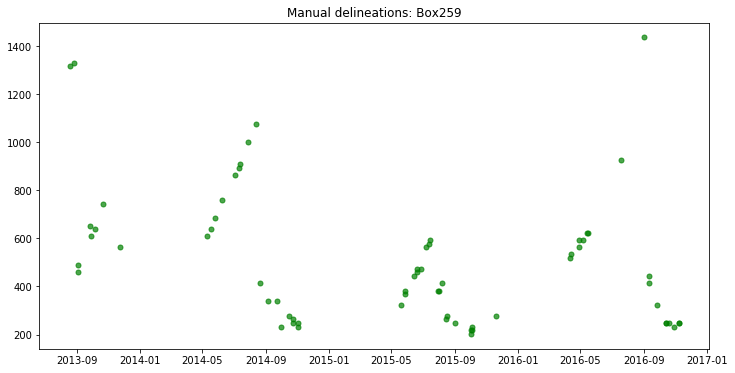

In [680]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df['datetimes'], df['tpos50'], 'go', markersize='5', alpha=0.7)
plt.title('Manual delineations: Box'+BOI)
plt.show()

## 7) Plot automated vs. manual time series and analyze difference

In [794]:
#Read in automated df
auto_df = pd.read_csv('/home/jukes/Documents/Sample_glaciers/Tpos_timeseries_Box'+BOI+'_filtered.csv', sep=',')

#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = auto_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
auto_df['datetimes'] = datetime_objs

In [682]:
# auto_df

In [795]:
#grab max and min dates from automated time series:
maxdate = np.max(list(auto_df['datetimes']))
mindate = np.min(list(auto_df['datetimes']))

#grab only manual delineations between those dates
df_2013 = df[df['datetimes'] > mindate].copy()
ls8_df = df_2013[df_2013['datetimes'] < maxdate].copy()

In [684]:
# df_2013

In [685]:
# ls8_df

In [686]:
# new_tpos = []

# for idx, row in auto_df.iterrows():
#     if row['term_position'] > 400.0:
#         new_tpos.append(np.nan)
#     else:
#         new_tpos.append(row['term_position'])

In [800]:
ls8_df.head()

,BoxID,datetimes,Line_x,Line_y,intersect_x,intersect_y,tpos50,tpos25,tpos75
407,120,2013-05-30,"[151, 150, 150, 149, 149, 149, 148, 147, 147, ...","[118, 119, 120, 121, 122, 123, 124, 125, 126, ...",150.0,150.0,585.432532,555.114009,511.115508
392,120,2013-08-18,"[150, 149, 149, 148, 148, 148, 147, 147, 147, ...","[118, 119, 120, 121, 122, 123, 124, 125, 126, ...",151.0,150.0,600.421727,540.117175,526.083703
434,120,2013-09-03,"[154, 153, 152, 149, 150, 151, 148, 148, 148, ...","[120, 121, 122, 123, 123, 123, 124, 125, 126, ...",151.0,150.0,600.421727,555.114009,511.115508
437,120,2013-09-12,"[154, 153, 153, 152, 150, 151, 152, 150, 149, ...","[115, 116, 117, 118, 119, 119, 119, 120, 121, ...",150.0,150.0,585.432532,525.120522,496.149234
409,120,2013-09-28,"[153, 153, 152, 152, 151, 152, 150, 151, 148, ...","[115, 116, 117, 118, 119, 119, 120, 120, 121, ...",149.0,150.0,570.443906,540.117175,511.115508


In [687]:
# auto_df['term_position'] = new_tpos

In [799]:
# #drop nans
# ls8_df = ls8_df.dropna()
# auto_df = auto_df.dropna()

# # #grab max terminus position across both
max_tpos_man = np.max(list(ls8_df['tpos50']))#+(2*15.0)
max_tpos_auto = np.max(list(auto_df['term_position']))+15.0
# max_Y = np.max([max_tpos_man, max_tpos_auto])
max_Y = max_tpos_man
# # max_tpos_man = 0
# # max_tpos_auto = 0
print(max_tpos_man, max_tpos_auto)
print(max_Y)

630.4016576754855 675.0
630.4016576754855


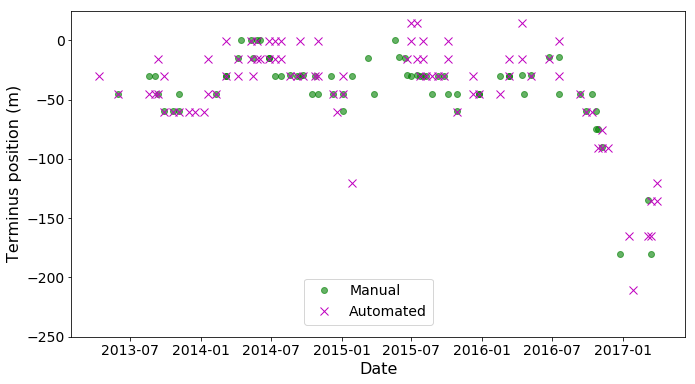

In [810]:
fig, ax1 = plt.subplots(figsize=(11,6))
# ax1.plot(ls8_df['datetimes'], np.array(ls8_df['term_position']) - max_tpos_man, 'go', markersize='5', alpha=0.6)
ax1.plot(ls8_df['datetimes'],np.array(ls8_df['tpos50']) - max_Y, 'go', markersize='6', alpha=0.6)
ax1.set_ylabel('Terminus position (m)', color='k', fontsize=16)

#Automated time series
# ax2 = ax1.twinx()
# ax1.plot(auto_df['datetimes'], np.array(auto_df['term_position'])+15, 'mx', markersize='8', alpha=1)
# ax1.plot(auto_df['datetimes'], np.array(auto_df['tpos'])- max_Y, 'mx', markersize='10', alpha=1)
ax1.plot(auto_df['datetimes'], np.array(auto_df['term_position'])+15 - max_Y, 'mx', markersize='8', alpha=1)
# ax2.set_ylabel('Auto terminus position (m)', color = 'k', fontsize=12)
# ax2.get_yaxis().set_visible(False) 

#GENERAL PLOT PARAMETERS
# ax1.set_title("Box"+BOI, fontsize=16)
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylim(-250, 25)
ax1.tick_params(axis='both', which='major', labelsize=14)
# ax2.tick_params(axis='both', which='major', labelsize=12)
fig.legend(['Manual', 'Automated'], bbox_to_anchor=(0.6,0.2), bbox_transform=ax1.transAxes, fontsize=14)
# fig.legend(['Manual', 'Automated'], fontsize=12)

#SAVE FIGURE
# plt.title("Box"+BOI)
# plt.grid()
plt.savefig("/media/jukes/jukes1/Manual/Manual_vs_automated_Box"+BOI+".png", dpi=500)
plt.show()

In [698]:
comparison_df = pd.merge(auto_df.drop(['BoxID', 'changerate','Order'], axis=1), ls8_df.drop(['Line_x', 'Line_y', 'BoxID'], axis=1), how='inner', on='datetimes')
comparison_df = comparison_df.dropna()

In [ ]:
comparison_df

In [ ]:
# #recalculate terminus position for either side
# comparison_df['term_position_x'] = np.array(comparison_df['term_position_x']) - max_tpos_auto
# comparison_df['term_position_y'] = np.array(comparison_df['term_position_y']) - max_tpos_man

In [703]:
comparison_df['auto_man_diff'] = np.array(comparison_df['tpos50']) - np.array(comparison_df['tpos']-350)
# comparison_df['auto_man_diff'] = np.array(comparison_df['term_position'])-350 - np.array(comparison_df['tpos50'])

In [704]:
differences = np.array(comparison_df.auto_man_diff)
print("Automated vs. manual delineations")
print(len(comparison_df))
print("Max difference: "+str(np.max(abs(differences)))+' meters')
print("Average difference: "+str(np.average(abs(differences)))+' meters')
print("Median difference: "+str(np.median(abs(differences)))+' meters')

Automated vs. manual delineations
28
Max difference: 906.7466390273212 meters
Average difference: 195.48568011536798 meters
Median difference: 59.91982529724453 meters


In [ ]:
93+12+84+37+13

In [ ]:
(93*61 + 12*212 + 84*15 + 37*28 + 13*401)/239

In [706]:
59.9/15

3.993333333333333